# Preliminaries

In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from kneed import KneeLocator


plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [2]:
#Load original dataframes
allDataCohort = pd.read_csv("../Data Validation/ARIC/Original DataFrames/AllDataAricCohort.csv", sep=",", index_col='ID')
allDataComm = pd.read_csv("../Data Validation/ARIC/Original DataFrames/AllDataAricComm.csv", sep=",", index_col='ID') 
hemoCohort = pd.read_csv("../Data Validation/ARIC/Original DataFrames/HemoAricCohort.csv", sep=",", index_col='ID') 
hemoComm = pd.read_csv("../Data Validation/ARIC/Original DataFrames/HemoAricComm.csv", sep=",", index_col='ID') 
cohortLabels = pd.read_csv("../Data Validation/ARIC/Original DataFrames/LabelsAricCohort.csv", sep=",", index_col='ID')
commLabels = pd.read_csv("../Data Validation/ARIC/Original DataFrames/LabelsAricComm.csv", sep=",", index_col='ID')
hemocohortLabels = pd.read_csv("../Data Validation/ARIC/Original DataFrames/HemoLabelsAricCohort.csv", sep=",", index_col='ID')
hemocommLabels = pd.read_csv("../Data Validation/ARIC/Original DataFrames/HemoLabelsAricComm.csv", sep=",", index_col='ID')


# Cluster Labels

In [3]:
#CLUSTERING FUNCTIONS
def clusterFindK(X): #find optimal num k
    sum_of_squared_distances = []
    silhouette = []
    K = range(1,16)
    for k in K:
        k_means = KMeans(n_clusters=k, init='k-means++',n_init=50, max_iter=500, tol=1e-04, random_state=0)
        model = k_means.fit(X)
        sum_of_squared_distances.append(k_means.inertia_)
        if k != 1:
            silhouette.append(silhouette_score(X, k_means.labels_))
        

    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('K Number of Clusters')
    plt.ylabel('Sum of Squared Error')
    plt.title('Elbow Method to Find Optimal K')
    plt.show()
    
    kl = KneeLocator(K, sum_of_squared_distances, curve="convex", direction="decreasing")
    print("Using the elbow method, the optimal number of clusters is", kl.elbow)
    
    plt.plot(range(2,16), silhouette)
    plt.xlabel("K Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()
    
    print("Using Silhouette Scores, the optimal number of clusters is", silhouette.index(max(silhouette))+2)
    
def kMeans(X, K): #perform k means clustering
    km = KMeans(n_clusters=K, init='k-means++',n_init=50, max_iter=500, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X)
    print("Lowest SSE", km.inertia_) #lowest sum of squared error value
    print("Number of iterations needed for convergence", km.n_iter_) #number of iterations neded to converge
    print("Y_km labels", y_km)
    
    return y_km

def plotPCAClusters(X, y_km, K, name): #plot clusters from pca
    df = pd.DataFrame(X, columns=["Component_1", "Component_2"])
    df['Cluster'] = y_km + 1
    plt.figure(figsize=(16,7))
    numColors = len(set(y_km))
    sns.scatterplot(x='Component_1', y='Component_2', hue='Cluster', palette=sns.color_palette('hls', numColors), data=df, legend='full')
    plt.title("Resulting Score Clusters")
    plt.savefig("Figures/Score_Clusters_" + name + ".png")

    plt.show()
    
    return df

def plotClusters(X, y_km, columns, K): #plot original data clusters
    X['cluster'] = y_km
    plt.figure(figsize=(16,7))
    numColors = len(set(y_km))
    sns.scatterplot(x=columns[0], y=columns[1], hue='cluster',palette=sns.color_palette('hls', numColors), data=X, legend='full')
    plt.show()
    
    return X

def compareClusters(dt, K): #compare details of clusters
    clusters = []
    clusterDesc = []
    for num in range(K):
        cls = dt[dt['cluster'] == num]
        clusters.append(cls)

        print("Cluster ", num)
        print(cls.describe())
        clusterDesc.append(cls.describe())
        
    return clusters, clusterDesc

#compare distributions of clusters
def distPlotsForClusters(cls, cols, name):
    clusters = copy.deepcopy(cls)
    for c in cols:
        f, ax = plt.subplots(figsize=(11,9))
        for i in range(len(clusters)):
            currCls = pd.DataFrame(clusters[i])
            currCls = currCls.replace(np.inf, 0)
            sns.distplot(currCls[c], ax=ax, label=i)
        
        plt.title(c+ ' Distribution by Cluster')
        plt.ylabel("Distribution Value")
        plt.legend(title="Cluster")
        
        plt.savefig("Figures/" + name + "/Clusters"+c+".png")

## Hemo Dataset - Cohort

In [4]:
#try clustering to find similar groups using PCA
hemo = copy.deepcopy(hemoCohort)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)
scaler = MinMaxScaler()#scale data
hemo.loc[:,:] = scaler.fit_transform(hemo)
pca = PCA(n_components=2)
data = pca.fit_transform(hemo)

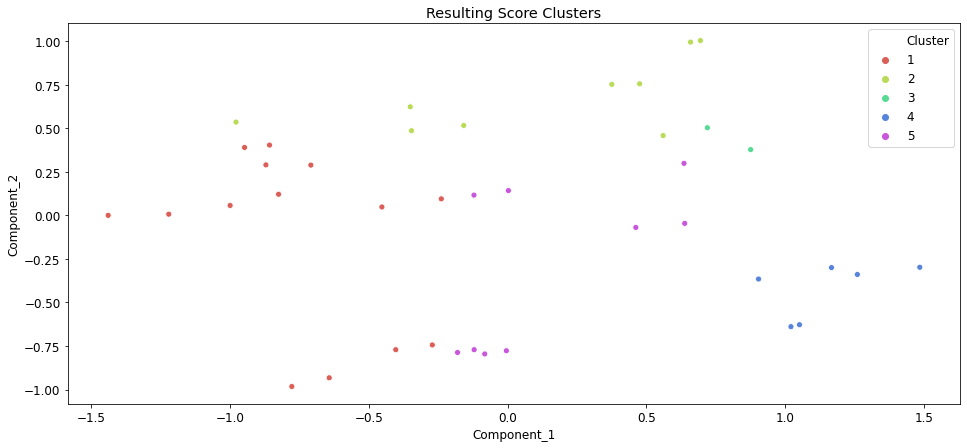

In [5]:
# y_km = kMeans(data, 5)
#load model
model = pickle.load(open('ClusterModels/HemoCluster.sav', 'rb'))
y_km = model.predict(data)

pcaDF = plotPCAClusters(data, y_km, 5, "Hemo_ARIC_Cohort")

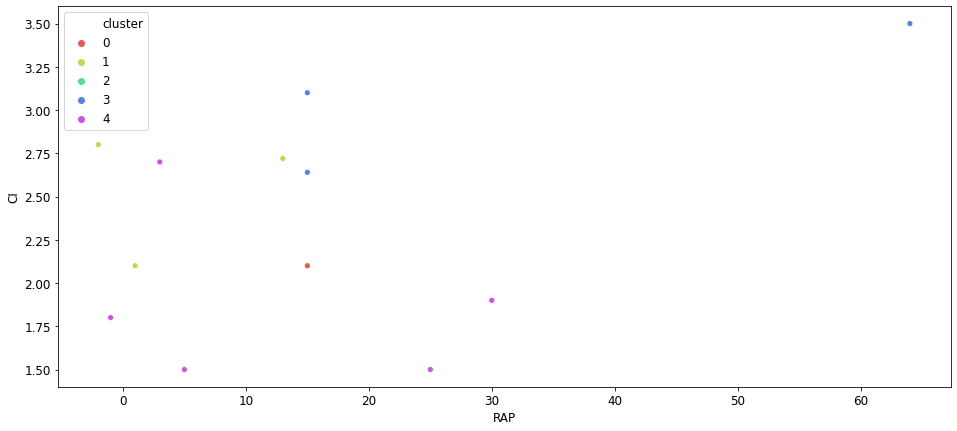

In [6]:
hemoDF = plotClusters(hemoCohort, y_km, ["RAP", "CI"], 5)

In [7]:
#Add class labels
hemoDF['Death'] = hemocohortLabels['Death']

clusters, clusterDesc = compareClusters(hemoDF, 5)

Cluster  0
             Age     Gender  Race        EjF        RAP         PAS   PAD  \
count  14.000000  14.000000  14.0  10.000000  14.000000   12.000000  14.0   
mean   73.285714   1.285714   1.0  37.000000  18.428571   58.333333   0.0   
std     5.539072   0.468807   0.0  16.193277  24.437406   29.656621   0.0   
min    66.000000   1.000000   1.0  20.000000   2.000000   24.000000   0.0   
25%    67.000000   1.000000   1.0  25.000000   5.000000   38.000000   0.0   
50%    77.000000   1.000000   1.0  30.000000  10.000000   50.000000   0.0   
75%    77.750000   1.750000   1.0  50.000000  15.000000   78.000000   0.0   
max    79.000000   2.000000   1.0  60.000000  75.000000  110.000000   0.0   

       PAMN       PCWP        CO  ...  PAPP           SVR        RAT  \
count  14.0  10.000000  6.000000  ...  14.0      6.000000  10.000000   
mean    0.0  21.800000  2.233333  ...   0.0   8272.826302   0.402078   
std     0.0   8.521867  1.748904  ...   0.0   7294.305944   0.226382   
min    

In [8]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_Hemo_ARIC_Cohort.csv")

In [9]:
hemoDF.to_csv("Clustered_HemoDF_ARIC_Cohort.csv")

Save preprocessed data  
Cluster --> Score   

In [10]:
#Get means for each cluster

clsScDF = pd.DataFrame()
clsScDF.index.name = 'Cluster'

scores = [1,2,3,4,5]
dthMn = descSummary.loc['mean']['Death'].to_numpy()

In [11]:
dthScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(dthMn):
    dthScores[v] = scores[cnt]
    cnt += 1
    
clsScDF['DeathMean'] = dthMn
clsScDF['DeathScores'] = dthScores

clsScDF

,DeathMean,DeathScores
0,0.571429,5
1,0.222222,4
2,0.000000,1
3,0.000000,2
4,0.000000,3


Make sure to add final scores assignment

In [12]:
#Save fully preprocessed score data
clusNums = hemoDF['cluster']

#Death Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['DeathScores']))
hemoDF['ScoreDeath'] = labels

hemoDF = hemoDF.drop(columns=["cluster"])
hemoDF = hemoDF.drop(columns=["Death"])


hemoDF

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,PPP,PAPP,SVR,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,ScoreDeath
ID,,,,,,,,,,,,,,,,,,,,,
S110616,74,2,1,25.0,25.0,64.0,0,0,23.0,2.50,...,0.465517,0,4234.666667,1.086957,0.794118,0,2.347826,39.0,2.160000,3
S110616,74,2,1,25.0,25.0,64.0,0,0,23.0,2.50,...,0.471698,0,3786.666667,1.086957,0.735294,0,2.173913,33.0,2.000000,3
S112447,66,2,1,60.0,8.0,110.0,0,0,12.0,NaN,...,0.522727,0,NaN,0.666667,1.210526,0,5.750000,51.0,8.625000,5
S112447,66,2,1,60.0,8.0,110.0,0,0,12.0,NaN,...,0.525316,0,NaN,0.666667,1.456140,0,6.916667,63.0,10.375000,5
S113841,79,1,1,NaN,15.0,45.0,0,0,25.0,4.40,...,0.371681,0,2642.424242,0.600000,0.466667,0,1.680000,46.0,2.800000,5
S113841,79,1,1,NaN,15.0,45.0,0,0,25.0,4.40,...,0.325000,0,1836.363636,0.600000,0.288889,0,1.040000,29.0,1.733333,5
S114430,71,1,2,10.0,-2.0,17.0,0,0,2.0,4.00,...,0.356643,0,4126.666667,-1.000000,0.520408,0,25.500000,90.0,-25.500000,4
S114430,71,1,2,10.0,-2.0,17.0,0,0,2.0,4.00,...,0.364865,0,4253.333333,-1.000000,0.551020,0,27.000000,92.0,-27.000000,4
S116317,74,1,2,45.0,NaN,NaN,0,0,15.0,NaN,...,0.527273,0,NaN,NaN,0.604167,0,3.866667,37.0,NaN,4


In [13]:
hemoDF.to_csv("../Data Validation/ARIC/Preprocessed Data/Clustered_HemoDF_ARIC_Cohort.csv")

## All Data - Cohort

In [14]:
#try clustering to find similar groups using PCA
allData = copy.deepcopy(allDataCohort)
allData = allData.replace(np.inf, 0)
allData = allData.fillna(0)
scaler = MinMaxScaler()#scale data
allData.loc[:,:] = scaler.fit_transform(allData)
pca = PCA(n_components=2)
data = pca.fit_transform(allData)

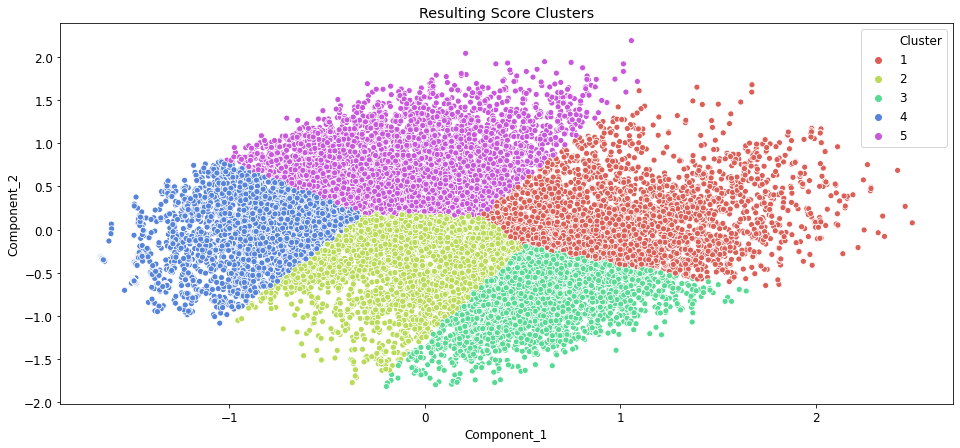

In [15]:
model = pickle.load(open('ClusterModels/AllDataCluster.sav', 'rb'))
y_km = model.predict(data)

pcaDF = plotPCAClusters(data, y_km, 5, 'AllData_ARIC_Cohort')

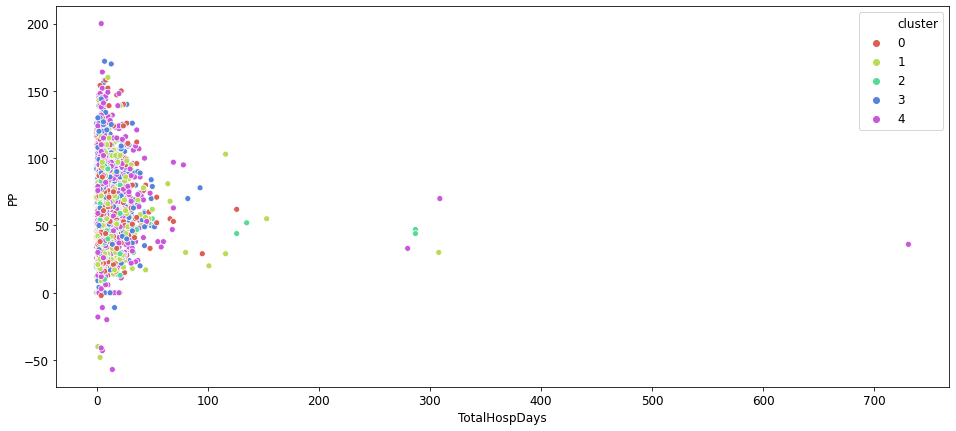

In [16]:
allDF = plotClusters(allDataCohort, y_km, ["TotalHospDays", "PP"], 5)

In [17]:
#Add class labels
allDF['Death'] = cohortLabels['Death']

clusters, clusterDesc = compareClusters(allDF, 5)

Cluster  0
               Age       Gender         Race           Wt          BMI  \
count  2754.000000  2754.000000  2754.000000  2354.000000  2657.000000   
mean     77.803922     1.360566     1.219680    84.187831    11.275668   
std       5.926175     0.480252     0.414105    19.909598    15.892794   
min      62.000000     1.000000     1.000000    32.295777     0.000000   
25%      73.000000     1.000000     1.000000    69.399633     0.000000   
50%      78.000000     1.000000     1.000000    81.646627     0.000000   
75%      82.000000     2.000000     1.000000    96.500000    25.990632   
max      93.000000     2.000000     2.000000   213.495000   200.413223   

       InitialHospDays  TotalHospDays        NYHA   MLHFS           AF  ...  \
count           2754.0    2754.000000  186.000000  2754.0  2754.000000  ...   
mean               0.0       6.607480    0.215054     0.0     0.778504  ...   
std                0.0      16.201518    0.789792     0.0     0.415329  ...   
min   

Cluster  4
               Age       Gender         Race           Wt          BMI  \
count  3964.000000  3964.000000  3964.000000  3378.000000  3781.000000   
mean     76.014127     1.594349     1.522704    85.316341     8.450607   
std       6.167631     0.491080     0.499547    20.720448    14.532263   
min      61.000000     1.000000     1.000000    26.807309     0.000000   
25%      72.000000     1.000000     1.000000    70.325000     0.000000   
50%      76.000000     2.000000     2.000000    83.256880     0.000000   
75%      80.000000     2.000000     2.000000    98.200000    21.300161   
max      92.000000     2.000000     2.000000   201.800000    74.033284   

       InitialHospDays  TotalHospDays        NYHA   MLHFS           AF  ...  \
count           3964.0    3959.000000  452.000000  3964.0  3964.000000  ...   
mean               0.0       7.068957    0.141593     0.0     0.023713  ...   
std                0.0      14.779157    0.657446     0.0     0.152174  ...   
min   

In [18]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_AllData_ARIC_Cohort.csv")

In [19]:
allDF.to_csv("Clustered_allDataDF_ARIC_Cohort.csv")

Save preprocessed data  
Cluster --> Score   

In [20]:
#Get means for each cluster

clsScDF = pd.DataFrame()
clsScDF.index.name = 'Cluster'

scores = [1,2,3,4,5]
dthMn = descSummary.loc['mean']['Death'].to_numpy()

In [21]:
dthScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(dthMn):
    dthScores[v] = scores[cnt]
    cnt += 1
    
clsScDF['DeathMean'] = dthMn
clsScDF['DeathScores'] = dthScores

clsScDF

,DeathMean,DeathScores
0,0.037400,2
1,0.086758,5
2,0.079371,4
3,0.070728,3
4,0.037336,1


Make sure to add final scores assignment

In [22]:
#Save fully preprocessed score data
clusNums = allDF['cluster']

#Death Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['DeathScores']))
allDF['ScoreDeath'] = labels

allDF = allDF.drop(columns=["cluster"])
allDF = allDF.drop(columns=["Death"])

allDF

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,EjF,BPDIAS,BPSYS,HR,PV,MAP,PP,PPP,PPRatio,ScoreDeath
ID,,,,,,,,,,,,,,,,,,,,,
S105655,76,1,1,NaN,0.000000,0,11.0,NaN,0,0,...,NaN,88.0,194.0,0,0,252.666667,106.0,0.546392,1.492958,1
S105655,76,1,1,NaN,NaN,0,11.0,NaN,0,0,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,1
S105737,76,2,1,67.70,0.000000,0,3.0,NaN,0,1,...,40.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,5
S105737,76,2,1,63.30,28.185923,0,3.0,NaN,0,1,...,40.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,4
S106083,66,2,1,86.00,0.000000,0,10.0,0.0,0,0,...,NaN,70.0,142.0,0,0,188.666667,72.0,0.507042,0.734694,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S214744,74,2,1,87.10,35.121038,0,3.0,NaN,0,1,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,2
S214752,80,2,1,66.90,0.000000,0,2.0,NaN,0,0,...,60.0,110.0,230.0,0,0,303.333333,120.0,0.521739,1.153846,3
S214752,80,2,1,67.10,24.616617,0,2.0,NaN,0,0,...,60.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,3


In [23]:
allDF.to_csv("../Data Validation/ARIC/Preprocessed Data/Clustered_AllData_ARIC_Cohort.csv")

## Hemo Dataset - Comm

In [24]:
#try clustering to find similar groups using PCA
hemo = copy.deepcopy(hemoComm)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)
scaler = MinMaxScaler()#scale data
hemo.loc[:,:] = scaler.fit_transform(hemo)
pca = PCA(n_components=2)
data = pca.fit_transform(hemo)

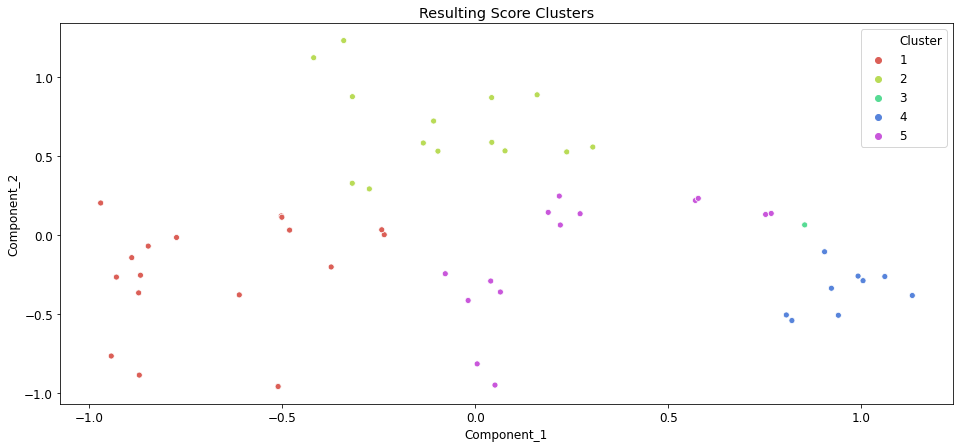

In [25]:
model = pickle.load(open('ClusterModels/HemoCluster.sav', 'rb'))
y_km = model.predict(data)

pcaDF = plotPCAClusters(data, y_km, 5, "Hemo_ARIC_Comm")

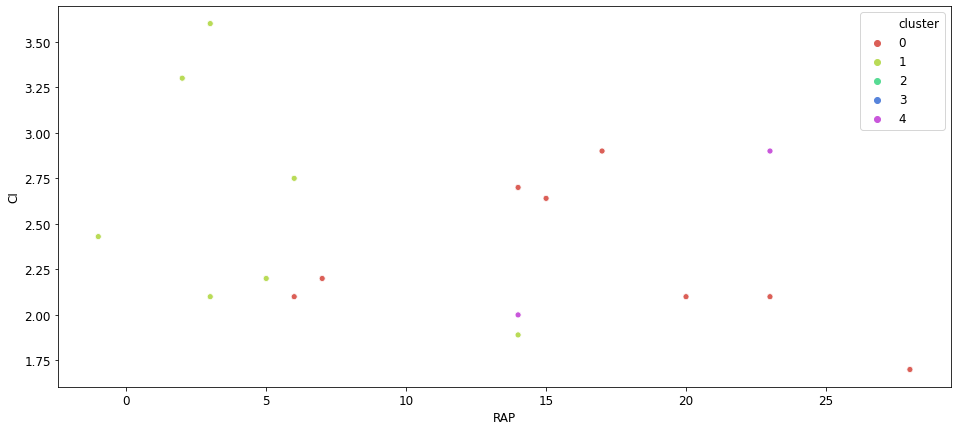

In [26]:
hemoDF = plotClusters(hemoComm, y_km, ["RAP", "CI"], 5)

In [27]:
#Add class labels
hemoDF['Death'] = hemocommLabels['Death']

clusters, clusterDesc = compareClusters(hemoDF, 5)

Cluster  0
             Age     Gender  Race        EjF        RAP        PAS   PAD  \
count  18.000000  18.000000  18.0  12.000000  18.000000  18.000000  18.0   
mean   71.555556   1.888889   0.0  44.833333  19.777778  56.333333   0.0   
std     5.447312   0.323381   0.0  16.573985  12.326707  21.616987   0.0   
min    62.000000   1.000000   0.0  25.000000   6.000000  25.000000   0.0   
25%    70.000000   2.000000   0.0  25.000000  14.000000  47.000000   0.0   
50%    70.000000   2.000000   0.0  47.500000  17.000000  56.000000   0.0   
75%    72.000000   2.000000   0.0  60.000000  23.000000  69.000000   0.0   
max    83.000000   2.000000   0.0  64.000000  48.000000  90.000000   0.0   

       PAMN       PCWP         CO  ...  PAPP          SVR        RAT  \
count  18.0  18.000000  18.000000  ...  18.0    16.000000  18.000000   
mean    0.0  24.333333   4.413333  ...   0.0  2976.004776   0.812404   
std     0.0   9.267273   0.955713  ...   0.0   598.786523   0.386258   
min     0.0   8.

In [28]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_Hemo_ARIC_Comm.csv")

In [29]:
hemoDF.to_csv("Clustered_HemoDF_ARIC_Comm.csv")

Save preprocessed data  
Cluster --> Score   

In [30]:
#Get means for each cluster

clsScDF = pd.DataFrame()
clsScDF.index.name = 'Cluster'

scores = [1,2,3,4,5]
dthMn = descSummary.loc['mean']['Death'].to_numpy()

In [31]:
dthScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(dthMn):
    dthScores[v] = scores[cnt]
    cnt += 1
    
clsScDF['DeathMean'] = dthMn
clsScDF['DeathScores'] = dthScores

clsScDF

,DeathMean,DeathScores
0,0.0,1
1,0.0,2
2,0.0,3
3,0.0,4
4,0.0,5


Make sure to add final scores assignment

In [32]:
#Save fully preprocessed score data
clusNums = hemoDF['cluster']

#Death Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['DeathScores']))
hemoDF['ScoreDeath'] = labels

hemoDF = hemoDF.drop(columns=["cluster"])
hemoDF = hemoDF.drop(columns=["Death"])


hemoDF

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,PPP,PAPP,SVR,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,ScoreDeath
ID,,,,,,,,,,,,,,,,,,,,,
S113719,55,1,0,10.0,23.0,29.0,0,0,20.0,NaN,...,0.220000,0,NaN,1.150000,0.224490,0,1.100000,58.0,0.956522,5
S113719,55,1,0,10.0,23.0,29.0,0,0,20.0,NaN,...,0.392000,0,NaN,1.150000,0.500000,0,2.450000,56.0,2.130435,5
S114046,61,1,0,NaN,14.0,35.0,0,0,16.0,3.80,...,0.183099,0,2014.035088,0.875000,0.097744,0,0.812500,42.0,0.928571,5
S114046,61,1,0,NaN,14.0,35.0,0,0,16.0,3.80,...,0.285714,0,1663.157895,0.875000,0.135338,0,1.125000,29.0,1.285714,5
S115069,60,1,0,NaN,3.0,23.0,0,0,3.0,3.30,...,0.764706,0,4694.949495,1.000000,1.262136,0,43.333333,37.0,43.333333,2
S115069,60,1,0,NaN,3.0,23.0,0,0,3.0,3.30,...,0.361905,0,3555.555556,1.000000,0.368932,0,12.666667,64.0,12.666667,2
S115472,60,1,0,55.0,3.0,43.0,0,0,24.0,7.70,...,0.545455,0,2649.350649,0.125000,1.333333,0,4.500000,66.0,36.000000,2
S115472,60,1,0,55.0,3.0,43.0,0,0,24.0,7.70,...,0.573171,0,2157.575758,0.125000,1.160494,0,3.916667,46.0,31.333333,2
S117776,83,2,0,NaN,6.0,26.0,0,0,13.0,3.50,...,0.258065,0,4099.047619,0.461538,0.283186,0,2.461538,79.0,5.333333,1


In [33]:
hemoDF.to_csv("../Data Validation/ARIC/Preprocessed Data/Clustered_HemoDF_ARIC_Comm.csv")

## All Data - Comm

In [34]:
#try clustering to find similar groups using PCA
allData = copy.deepcopy(allDataComm)
allData = allData.replace(np.inf, 0)
allData = allData.fillna(0)
scaler = MinMaxScaler()#scale data
allData.loc[:,:] = scaler.fit_transform(allData)
pca = PCA(n_components=2)
data = pca.fit_transform(allData)

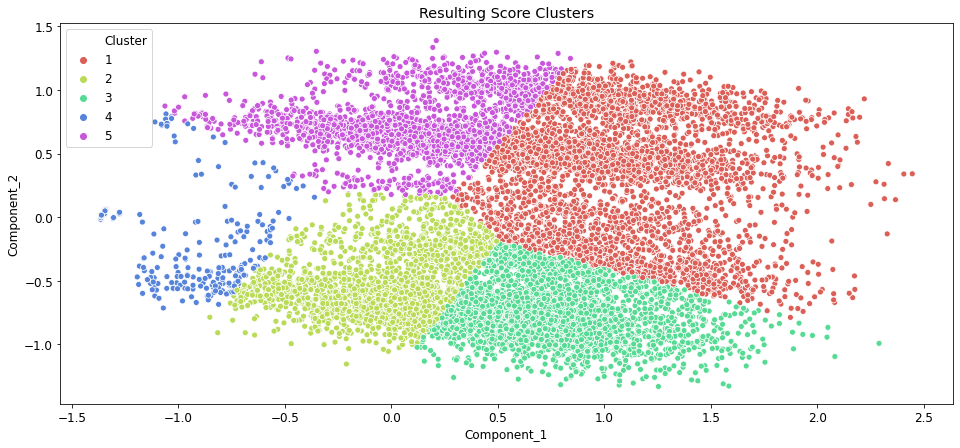

In [35]:

model = pickle.load(open('ClusterModels/AllDataCluster.sav', 'rb'))
y_km = model.predict(data)

pcaDF = plotPCAClusters(data, y_km, 5, 'AllData_ARIC_Comm')

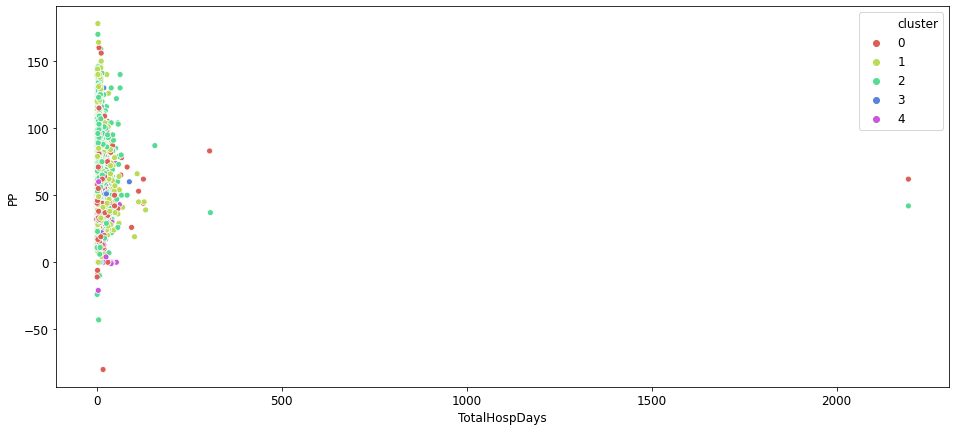

In [36]:
allDF = plotClusters(allDataComm, y_km, ["TotalHospDays", "PP"], 5)

In [37]:
#Add class labels
allDF['Death'] = commLabels['Death']

clusters, clusterDesc = compareClusters(allDF, 5)

Cluster  0
               Age       Gender    Race           Wt          BMI  \
count  4103.000000  4103.000000  4103.0  3307.000000  3628.000000   
mean     70.871070     1.460151     0.0    89.027134    24.687209   
std       8.444138     0.498470     0.0    25.107696    16.264046   
min      55.000000     1.000000     0.0    22.452822     0.000000   
25%      64.000000     1.000000     0.0    71.750000    19.453401   
50%      71.000000     1.000000     0.0    85.280000    27.154708   
75%      78.000000     2.000000     0.0   102.000000    33.731796   
max      85.000000     2.000000     0.0   220.800000   301.623970   

       InitialHospDays  TotalHospDays        NYHA   MLHFS           AF  ...  \
count           4103.0    4103.000000  393.000000  4103.0  4103.000000  ...   
mean               0.0       7.983183    0.221374     0.0     0.480868  ...   
std                0.0      36.080460    0.829526     0.0     0.499695  ...   
min                0.0       0.000000    0.000000  

Cluster  4
               Age       Gender    Race           Wt          BMI  \
count  2320.000000  2320.000000  2320.0  1666.000000  1931.000000   
mean     71.040086     1.509052     0.0    85.116659    30.055665   
std       8.502473     0.500026     0.0    29.777768    11.426914   
min      55.000000     1.000000     0.0    23.425324     0.000000   
25%      64.000000     1.000000     0.0    65.500000    23.171517   
50%      72.000000     2.000000     0.0    80.233000    27.809560   
75%      78.000000     2.000000     0.0    99.175000    34.678059   
max      84.000000     2.000000     0.0   567.600000   172.176309   

       InitialHospDays  TotalHospDays       NYHA   MLHFS           AF  ...  \
count           2320.0    2320.000000  83.000000  2320.0  2320.000000  ...   
mean               0.0       8.010776   0.108434     0.0     0.265086  ...   
std                0.0       9.013351   0.563353     0.0     0.441474  ...   
min                0.0       0.000000   0.000000     0.

In [38]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_AllData_ARIC_Comm.csv")

In [39]:
allDF.to_csv("Clustered_allDataDF_ARIC_Comm.csv")

Save preprocessed data  
Cluster --> Score   

In [40]:
#Get means for each cluster

clsScDF = pd.DataFrame()
clsScDF.index.name = 'Cluster'

scores = [1,2,3,4,5]
dthMn = descSummary.loc['mean']['Death'].to_numpy()

In [41]:
dthScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(dthMn):
    dthScores[v] = scores[cnt]
    cnt += 1
    
clsScDF['DeathMean'] = dthMn
clsScDF['DeathScores'] = dthScores

clsScDF

,DeathMean,DeathScores
0,0.002925,2
1,0.005015,4
2,0.004161,3
3,0.001574,1
4,0.011207,5


Make sure to add final scores assignment

In [42]:
#Save fully preprocessed score data
clusNums = allDF['cluster']

#Death Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['DeathScores']))
allDF['ScoreDeath'] = labels

allDF = allDF.drop(columns=["cluster"])
allDF = allDF.drop(columns=["Death"])

allDF

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,EjF,BPDIAS,BPSYS,HR,PV,MAP,PP,PPP,PPRatio,ScoreDeath
ID,,,,,,,,,,,,,,,,,,,,,
S106083,66,2,0,86.000,0.000000,0,10,0.0,0,0,...,NaN,70.0,142.0,0,0,188.666667,72.0,0.507042,0.734694,3
S106083,66,2,0,88.500,36.865164,0,10,0.0,0,0,...,NaN,72.0,128.0,0,0,176.000000,56.0,0.437500,0.571429,2
S106611,67,1,0,80.200,0.000000,0,5,4.0,0,0,...,30.0,85.0,192.0,0,0,248.666667,107.0,0.557292,1.445946,3
S106611,67,1,0,75.000,24.417188,0,5,4.0,0,0,...,30.0,72.0,148.0,0,0,196.000000,76.0,0.513514,1.027027,2
S106644,76,2,0,57.200,0.000000,0,5,0.0,0,1,...,NaN,65.0,163.0,0,0,206.333333,98.0,0.601227,1.126437,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S210889,80,2,0,55.792,20.468112,0,5,NaN,0,1,...,20.0,75.0,135.0,0,0,185.000000,60.0,0.444444,0.937500,5
S210906,82,2,0,NaN,0.000000,0,3,NaN,0,0,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,1
S210906,82,2,0,NaN,NaN,0,3,NaN,0,0,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,1


In [43]:
allDF.to_csv("../Data Validation/ARIC/Preprocessed Data/Clustered_AllData_ARIC_Comm.csv")